In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn import linear_model

import tensorflow as tf
from tensorflow.keras.layers import Input, Layer, Lambda, Dropout, Reshape, Dense
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from tensorflow import keras

import scipy.sparse as sp

from stellargraph import StellarGraph
import stellargraph as sg
from stellargraph.layer.gcn import GraphConvolution, GatherIndices
from stellargraph.mapper import GraphSAGELinkGenerator, GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import UnsupervisedSampler

import warnings
import random
import umap
import math

In [2]:
np.random.seed(42)

In [3]:
data = pd.read_csv("C:\\Users\\Wilson\\Downloads\\Gravity_csv_V202211\\Gravity_V202211.csv")

C:\Users\Wilson\AppData\Local\Temp\ipykernel_16848\3341738873.py:1: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("C:\\Users\\Wilson\\Downloads\\Gravity_csv_V202211\\Gravity_V202211.csv")


# Data Cleanup/Formating

In [4]:
df = data[data['tradeflow_comtrade_o'].notna()]
df = df[df['tradeflow_comtrade_d'].notna()]
df = df[df['gdp_o'].notna()]
df = df[df['dist'].notna()]
df = df[df['gdp_d'].notna()]

In [5]:
df2018 = df[df['year'] == 2018]
unique_o = df2018.drop_duplicates(subset=['country_id_o'], keep='first')
unique_d = df2018.drop_duplicates(subset=['country_id_d'], keep='first')
nodes_o = unique_o[["country_id_o","gdp_o"]]
nodes_d = unique_d[["country_id_d","gdp_d"]]
nodes_d = nodes_d.rename(
    columns={"country_id_d" : "country_id_o", "gdp_d" : "gdp_o"}
)
nodes = pd.concat([nodes_o, nodes_d])
nodes = nodes.drop_duplicates(subset=['country_id_o'], keep='first')
nodes = nodes.set_index('country_id_o')

In [6]:
edges1 = df2018[["country_id_o", "country_id_d","tradeflow_comtrade_o", "tradeflow_comtrade_d", "dist"]]
target = edges1.tradeflow_comtrade_o + edges1.tradeflow_comtrade_d
edges1 = edges1.rename(
    columns={"country_id_o" : "source", "country_id_d" : "target", "dist": "weight"}
)
trade_out = edges1.pop('tradeflow_comtrade_o')
trade_in = edges1.pop('tradeflow_comtrade_d')
edges1['weight'] = np.log(edges1['weight'])
nodes['gdp_o'] = np.log(nodes['gdp_o'])

# Visualization

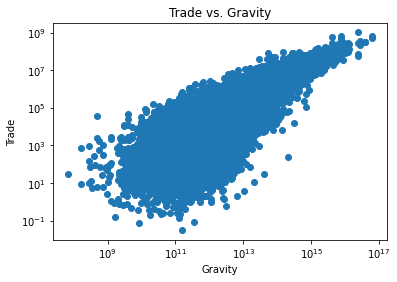

In [7]:
plt.yscale("log")
plt.xscale("log")
plt.scatter(df2018.gdp_o*df2018.gdp_d/df2018.dist, df2018.tradeflow_comtrade_o + df2018.tradeflow_comtrade_d)
plt.title("Trade vs. Gravity")
plt.xlabel("Gravity")
plt.ylabel("Trade")
plt.show()

# Weights from Distances

In [8]:
maxdist = max(edges1.weight)
maxdist
edges1.weight = 1 - edges1.weight/maxdist

# Graph Format

In [9]:
G = StellarGraph(nodes, edges1)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 164, Edges: 17879

 Node types:
  default: [164]
    Features: float32 vector, length 1
    Edge types: default-default->default

 Edge types:
    default-default->default: [17879]
        Weights: range=[0, 0.789955], mean=0.133525, std=0.0866327
        Features: none


In [10]:
# Adapted from https://antonsruberts.github.io/graph/gcn/ by Anton Ruberts
A = G.to_adjacency_matrix(weighted = False)
A_t = A + sp.diags(np.ones(A.shape[0]) - A.diagonal())
D_t = sp.diags(np.power(np.array(A.sum(1)), -0.5).flatten(), 0)
A_norm = A.dot(D_t).transpose().dot(D_t).todense()
features_input = np.expand_dims(nodes, 0)
A_input = np.expand_dims(A_norm, 0)

# GCN

In [11]:
# Adapted from https://antonsruberts.github.io/graph/gcn/ by Anton Ruberts
# Initialise GCN parameters
kernel_initializer="glorot_uniform"
bias = True
bias_initializer="zeros"
n_layers = 2
layer_sizes = [32, 32]
dropout = 0.5
n_features = features_input.shape[2]
n_nodes = features_input.shape[1]

In [12]:
# Adapted from https://antonsruberts.github.io/graph/gcn/ by Anton Ruberts
# Initialise input layers
x_features = Input(batch_shape=(1, n_nodes, n_features))
x_indices = Input(batch_shape=(1, None), dtype="int32")
x_adjacency = Input(batch_shape=(1, n_nodes, n_nodes))
x_inp = [x_features, x_indices, x_adjacency]

In [13]:
# Adapted from https://antonsruberts.github.io/graph/gcn/ by Anton Ruberts
# Build the model
x = Dropout(0.5)(x_features)
x = GraphConvolution(8, activation='relu', 
                     use_bias=True,
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer)([x, x_adjacency])
x = Dropout(0.5)(x)
x = GraphConvolution(8, activation='relu', 
                     use_bias=True,
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer)([x, x_adjacency])

x = GatherIndices(batch_dims=1)([x, x_indices])
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[x_features, x_indices, x_adjacency], outputs=output)

# Print out the summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(1, 164, 1)]        0           []                               
                                                                                                  
 dropout (Dropout)              (1, 164, 1)          0           ['input_1[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(1, 164, 164)]      0           []                               
                                                                                                  
 graph_convolution (GraphConvol  (1, 164, 8)         16          ['dropout[0][0]',                
 ution)                                                           'input_3[0][0]']            

In [14]:
# Adapted from https://antonsruberts.github.io/graph/gcn/ by Anton Ruberts
def get_node_indices(G, ids):
    # find the indices of the nodes
    node_ids = np.asarray(ids)
    flat_node_ids = node_ids.reshape(-1)

    flat_node_indices = G.node_ids_to_ilocs(flat_node_ids) # in-built function makes it really easy
    # back to the original shape
    node_indices = flat_node_indices.reshape(1, len(node_ids)) # add 1 extra dimension
    
    return node_indices

# Define the embedding model
embedding_model = Model(inputs=x_inp, outputs=model.layers[-2].output)

# Get indices of all nodes
#all_indices = get_node_indices(G, targets.index)
targets = edges1.index.astype(str)
all_indices = get_node_indices(G, nodes.index)

#Get embeddings
emb = embedding_model.predict([features_input, all_indices, A_input])
print(emb.shape)

1/1 [==============================] - 0s 286ms/step
(1, 164, 8)


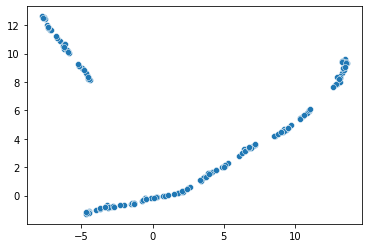

In [15]:
# Adapted from https://antonsruberts.github.io/graph/gcn/ by Anton Ruberts
# UMAP for visualisation
u = umap.UMAP(random_state=42)
umap_embs = u.fit_transform(emb[0])

#Plot the embeddingsembe
#plt.figure(figsize=(20,10))
ax = sns.scatterplot(x = umap_embs[:, 0], y = umap_embs[:, 1])

In [16]:
embededNode= pd.DataFrame(data=emb[0])
embededNode['Country'] = nodes.index
embededNode = embededNode.set_index('Country')

# MLP data setup

In [17]:
In = list()
Out = list()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
for edge in edges1.source.to_numpy():
    Out.append(embededNode.loc[[edge]])
for edge in edges1.target.to_numpy():
    In.append(embededNode.loc[[edge]])
Out = np.reshape(Out,(17879,8))
In = np.reshape(In,(17879,8))
Out = pd.DataFrame(Out)
In = pd.DataFrame(In)

In [18]:
mlpIn = pd.concat([Out,In], axis = 1, ignore_index = True)
mlpIn['weight'] = edges1['weight'].values

# MLP

In [19]:
scaler = StandardScaler()
mlpIn_scaled = scaler.fit_transform(mlpIn)

In [20]:
x_train, x_test, y_train, y_test = train_test_split(mlpIn_scaled, target, train_size= .66)
x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, train_size= .50)

In [21]:
model2 = keras.Sequential(
    [
        keras.Input( shape=(len(mlpIn.columns),) ),
        layers.Dense(40, activation="relu"),
        layers.Dense(20, activation="relu"),
        layers.Dense(1)
    ]
)

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 40)                720       
                                                                 
 dense_2 (Dense)             (None, 20)                820       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,561
Trainable params: 1,561
Non-trainable params: 0
_________________________________________________________________


In [22]:
model2.compile(loss = 'mean_squared_error',
             optimizer = 'adam')

In [23]:
fit = model2.fit(x_train, np.log(y_train), epochs=400, validation_data=(x_validation, np.log(y_validation)))

Epoch 1/400
369/369 [==============================] - 1s 2ms/step - loss: 26.2638 - val_loss: 6.1721
Epoch 2/400
369/369 [==============================] - 0s 1ms/step - loss: 5.2471 - val_loss: 4.6368
Epoch 3/400
369/369 [==============================] - 0s 1ms/step - loss: 4.6322 - val_loss: 4.4073
Epoch 4/400
369/369 [==============================] - 0s 1ms/step - loss: 4.5612 - val_loss: 4.3437
Epoch 5/400
369/369 [==============================] - 1s 1ms/step - loss: 4.5446 - val_loss: 4.2652
Epoch 6/400
369/369 [==============================] - 0s 1ms/step - loss: 4.5049 - val_loss: 4.2504
Epoch 7/400
369/369 [==============================] - 0s 1ms/step - loss: 4.4868 - val_loss: 4.2613
Epoch 8/400
369/369 [==============================] - 0s 1ms/step - loss: 4.4721 - val_loss: 4.2790
Epoch 9/400
369/369 [==============================] - 0s 1ms/step - loss: 4.4629 - val_loss: 4.2121
Epoch 10/400
369/369 [==============================] - 0s 1ms/step - loss: 4.4323 - val_l

369/369 [==============================] - 0s 1ms/step - loss: 4.2273 - val_loss: 4.0489
Epoch 82/400
369/369 [==============================] - 0s 1ms/step - loss: 4.2119 - val_loss: 4.0266
Epoch 83/400
369/369 [==============================] - 0s 1ms/step - loss: 4.2377 - val_loss: 4.0113
Epoch 84/400
369/369 [==============================] - 0s 1ms/step - loss: 4.2253 - val_loss: 4.0386
Epoch 85/400
369/369 [==============================] - 0s 1ms/step - loss: 4.2319 - val_loss: 3.9991
Epoch 86/400
369/369 [==============================] - 0s 1ms/step - loss: 4.2187 - val_loss: 4.0736
Epoch 87/400
369/369 [==============================] - 0s 1ms/step - loss: 4.2128 - val_loss: 4.0194
Epoch 88/400
369/369 [==============================] - 0s 1ms/step - loss: 4.2120 - val_loss: 4.0021
Epoch 89/400
369/369 [==============================] - 0s 1ms/step - loss: 4.2132 - val_loss: 4.0496
Epoch 90/400
369/369 [==============================] - 0s 1ms/step - loss: 4.2099 - val_loss: 

Epoch 161/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1721 - val_loss: 3.9782
Epoch 162/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1740 - val_loss: 4.1323
Epoch 163/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1808 - val_loss: 4.1058
Epoch 164/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1607 - val_loss: 4.0228
Epoch 165/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1807 - val_loss: 4.0521
Epoch 166/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1779 - val_loss: 4.1288
Epoch 167/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1746 - val_loss: 4.0218
Epoch 168/400
369/369 [==============================] - 1s 1ms/step - loss: 4.1737 - val_loss: 4.0089
Epoch 169/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1845 - val_loss: 4.0266
Epoch 170/400
369/369 [==============================] - 0s 1ms/step - lo

369/369 [==============================] - 0s 1ms/step - loss: 4.1452 - val_loss: 4.0994
Epoch 241/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1469 - val_loss: 4.0099
Epoch 242/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1416 - val_loss: 4.1305
Epoch 243/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1591 - val_loss: 4.0063
Epoch 244/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1413 - val_loss: 4.0091
Epoch 245/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1512 - val_loss: 3.9909
Epoch 246/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1349 - val_loss: 3.9708
Epoch 247/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1456 - val_loss: 3.9861
Epoch 248/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1461 - val_loss: 3.9758
Epoch 249/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1581 - v

369/369 [==============================] - 0s 1ms/step - loss: 4.1189 - val_loss: 3.9806
Epoch 320/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1315 - val_loss: 4.0831
Epoch 321/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1099 - val_loss: 3.9650
Epoch 322/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1163 - val_loss: 4.0120
Epoch 323/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1085 - val_loss: 3.9649
Epoch 324/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1267 - val_loss: 4.0006
Epoch 325/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1256 - val_loss: 3.9905
Epoch 326/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1154 - val_loss: 4.0320
Epoch 327/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1323 - val_loss: 3.9772
Epoch 328/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1208 - v

369/369 [==============================] - 0s 1ms/step - loss: 4.1066 - val_loss: 3.9683
Epoch 399/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1061 - val_loss: 3.9737
Epoch 400/400
369/369 [==============================] - 0s 1ms/step - loss: 4.0986 - val_loss: 4.0159


95/95 [==============================] - 0s 755us/step


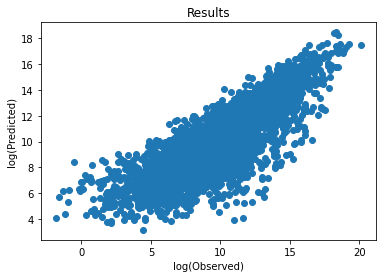

In [24]:
test_restul = model2.evaluate(x_test, np.log(y_test))
math.sqrt(test_restul)
yhat = model2.predict(x_test)
plt.scatter(np.log(y_test), yhat)
plt.title("Results")
plt.xlabel("log(Observed)")
plt.ylabel("log(Predicted)")
plt.show()

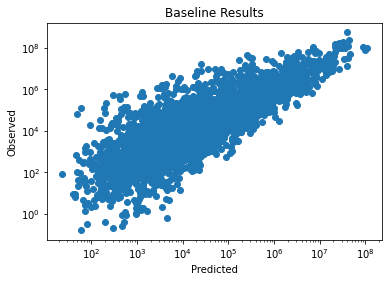

In [25]:
plt.yscale("log")
plt.xscale("log")
plt.scatter(np.exp(yhat), y_test)
plt.title("Baseline Results")
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.show()

# Test vs no GCN

In [26]:
simpleX = df2018[['dist','gdp_o','gdp_d']]
simpleY = df2018.tradeflow_comtrade_o + df2018.tradeflow_comtrade_d

In [27]:
simpleX = np.log(simpleX)
simpleY = np.log(simpleY)
scaler = StandardScaler()
mlpIn_scaled = scaler.fit_transform(simpleX)
x_train, x_test, y_train, y_test = train_test_split(mlpIn_scaled, simpleY, train_size= .66)
x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, train_size= .50)

In [28]:
model3 = keras.Sequential(
    [
        keras.Input( shape= 3,) ,
        layers.Dense(3, activation="relu"),
        layers.Dense(2, activation="relu"),
        layers.Dense(1)
    ]
)

model3.summary()
model3.compile(loss = 'mean_squared_error',
             optimizer = 'adam')
fit = model3.fit(x_train, y_train, epochs=400, validation_data=(x_validation, y_validation))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 3)                 12        
                                                                 
 dense_5 (Dense)             (None, 2)                 8         
                                                                 
 dense_6 (Dense)             (None, 1)                 3         
                                                                 
Total params: 23
Trainable params: 23
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
369/369 [==============================] - 1s 2ms/step - loss: 77.9467 - val_loss: 50.6094
Epoch 2/400
369/369 [==============================] - 0s 1ms/step - loss: 36.6722 - val_loss: 27.9534
Epoch 3/400
369/369 [==============================] - 0s 1ms/step - loss: 21.6521 - val_loss: 16.7941
Epoch 4/400
3

369/369 [==============================] - 0s 1ms/step - loss: 3.7840 - val_loss: 3.8199
Epoch 74/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7832 - val_loss: 3.8196
Epoch 75/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7832 - val_loss: 3.8153
Epoch 76/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7837 - val_loss: 3.8123
Epoch 77/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7826 - val_loss: 3.8158
Epoch 78/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7822 - val_loss: 3.8173
Epoch 79/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7815 - val_loss: 3.8121
Epoch 80/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7811 - val_loss: 3.8098
Epoch 81/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7807 - val_loss: 3.8050
Epoch 82/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7813 - val_loss: 

Epoch 153/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7606 - val_loss: 3.8004
Epoch 154/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7613 - val_loss: 3.7983
Epoch 155/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7604 - val_loss: 3.7952
Epoch 156/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7622 - val_loss: 3.8001
Epoch 157/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7618 - val_loss: 3.7979
Epoch 158/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7600 - val_loss: 3.8033
Epoch 159/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7591 - val_loss: 3.8071
Epoch 160/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7604 - val_loss: 3.8031
Epoch 161/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7601 - val_loss: 3.8033
Epoch 162/400
369/369 [==============================] - 0s 1ms/step - lo

369/369 [==============================] - 0s 1ms/step - loss: 3.7403 - val_loss: 3.7718
Epoch 233/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7368 - val_loss: 3.7937
Epoch 234/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7385 - val_loss: 3.7803
Epoch 235/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7396 - val_loss: 3.7728
Epoch 236/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7374 - val_loss: 3.7804
Epoch 237/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7369 - val_loss: 3.7796
Epoch 238/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7353 - val_loss: 3.7729
Epoch 239/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7343 - val_loss: 3.7730
Epoch 240/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7365 - val_loss: 3.7786
Epoch 241/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7347 - v

369/369 [==============================] - 0s 1ms/step - loss: 3.7166 - val_loss: 3.7708
Epoch 312/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7156 - val_loss: 3.7674
Epoch 313/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7155 - val_loss: 3.7621
Epoch 314/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7196 - val_loss: 3.7637
Epoch 315/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7158 - val_loss: 3.7626
Epoch 316/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7153 - val_loss: 3.7761
Epoch 317/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7174 - val_loss: 3.7642
Epoch 318/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7189 - val_loss: 3.7647
Epoch 319/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7171 - val_loss: 3.7639
Epoch 320/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7179 - v

369/369 [==============================] - 0s 1ms/step - loss: 3.7159 - val_loss: 3.7651
Epoch 391/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7141 - val_loss: 3.7840
Epoch 392/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7178 - val_loss: 3.7634
Epoch 393/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7186 - val_loss: 3.7652
Epoch 394/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7168 - val_loss: 3.7721
Epoch 395/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7171 - val_loss: 3.7664
Epoch 396/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7169 - val_loss: 3.7753
Epoch 397/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7187 - val_loss: 3.7659
Epoch 398/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7178 - val_loss: 3.7637
Epoch 399/400
369/369 [==============================] - 0s 1ms/step - loss: 3.7178 - v

95/95 [==============================] - 0s 755us/step


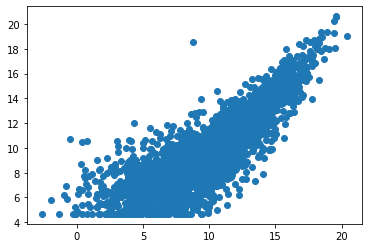

In [29]:
test_restul = model3.evaluate(x_test, y_test)
math.sqrt(test_restul)
yhat = model3.predict(x_test)
plt.scatter(y_test, yhat)

# Added Data

In [30]:
edges2 = df2018[["country_id_o", "country_id_d","tradeflow_comtrade_o", "tradeflow_comtrade_d", "dist", "comlang_off", "comlang_ethno", "comcol", "col45", "comleg_pretrans", "comleg_posttrans", "transition_legalchange","comrelig", "col_dep_ever", "col_dep", "sibling_ever", "sibling"]]
edges2 = edges2.replace(np.nan,0)
edges2 = edges2.rename(
    columns={"country_id_o" : "source", "country_id_d" : "target", "dist": "weight"}
)
trade_out = edges2.pop('tradeflow_comtrade_o')
trade_in = edges2.pop('tradeflow_comtrade_d')
edges2['weight'] = np.log(edges2['weight'])

In [31]:
G = StellarGraph(nodes, edges2)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 164, Edges: 17879

 Node types:
  default: [164]
    Features: float32 vector, length 1
    Edge types: default-default->default

 Edge types:
    default-default->default: [17879]
        Weights: range=[2.07944, 9.89998], mean=8.57809, std=0.857662
        Features: float32 vector, length 12


In [32]:
# Adapted from https://antonsruberts.github.io/graph/gcn/ by Anton Ruberts
A = G.to_adjacency_matrix(weighted=True)
A_t = A + sp.diags(np.ones(A.shape[0]) - A.diagonal())
D_t = sp.diags(np.power(np.array(A.sum(1)), -0.5).flatten(), 0)
A_norm = A.dot(D_t).transpose().dot(D_t).todense()
features_input = np.expand_dims(nodes, 0)
A_input = np.expand_dims(A_norm, 0)

In [33]:
# Adapted from https://antonsruberts.github.io/graph/gcn/ by Anton Ruberts
# Initialise GCN parameters
kernel_initializer="glorot_uniform"
bias = True
bias_initializer="zeros"
n_layers = 2
layer_sizes = [32, 32]
dropout = 0.5
n_features = features_input.shape[2]
n_nodes = features_input.shape[1]

In [34]:
# Adapted from https://antonsruberts.github.io/graph/gcn/ by Anton Ruberts
# Initialise input layers
x_features = Input(batch_shape=(1, n_nodes, n_features))
x_indices = Input(batch_shape=(1, None), dtype="int32")
x_adjacency = Input(batch_shape=(1, n_nodes, n_nodes))
x_inp = [x_features, x_indices, x_adjacency]

In [35]:
# Adapted from https://antonsruberts.github.io/graph/gcn/ by Anton Ruberts
# Build the model
x = Dropout(0.5)(x_features)
x = GraphConvolution(8, activation='relu', 
                     use_bias=True,
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer)([x, x_adjacency])
x = Dropout(0.5)(x)
x = GraphConvolution(8, activation='relu', 
                     use_bias=True,
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer)([x, x_adjacency])

x = GatherIndices(batch_dims=1)([x, x_indices])
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[x_features, x_indices, x_adjacency], outputs=output)

# Print out the summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(1, 164, 1)]        0           []                               
                                                                                                  
 dropout_2 (Dropout)            (1, 164, 1)          0           ['input_6[0][0]']                
                                                                                                  
 input_8 (InputLayer)           [(1, 164, 164)]      0           []                               
                                                                                                  
 graph_convolution_2 (GraphConv  (1, 164, 8)         16          ['dropout_2[0][0]',              
 olution)                                                         'input_8[0][0]']          

In [36]:
# Adapted from https://antonsruberts.github.io/graph/gcn/ by Anton Ruberts
def get_node_indices(G, ids):
    # find the indices of the nodes
    node_ids = np.asarray(ids)
    flat_node_ids = node_ids.reshape(-1)

    flat_node_indices = G.node_ids_to_ilocs(flat_node_ids) # in-built function makes it really easy
    # back to the original shape
    node_indices = flat_node_indices.reshape(1, len(node_ids)) # add 1 extra dimension
    
    return node_indices

# Define the embedding model
embedding_model = Model(inputs=x_inp, outputs=model.layers[-2].output)

# Get indices of all nodes
#all_indices = get_node_indices(G, targets.index)
targets = edges1.index.astype(str)
all_indices = get_node_indices(G, nodes.index)

#Get embeddings
emb = embedding_model.predict([features_input, all_indices, A_input])
print(emb.shape)

1/1 [==============================] - 0s 77ms/step
(1, 164, 8)


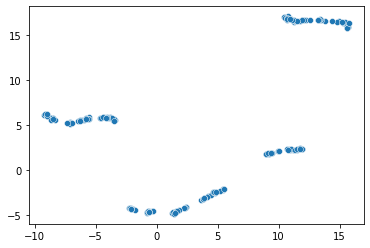

In [37]:
# Adapted from https://antonsruberts.github.io/graph/gcn/ by Anton Ruberts
# UMAP for visualisation
u = umap.UMAP(random_state=42)
umap_embs = u.fit_transform(emb[0])

#Plot the embeddingsembe
#plt.figure(figsize=(20,10))
ax = sns.scatterplot(x = umap_embs[:, 0], y = umap_embs[:, 1])

In [38]:
embededNode= pd.DataFrame(data=emb[0])
embededNode['Country'] = nodes.index
embededNode = embededNode.set_index('Country')

In [39]:
In = list()
Out = list()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
for edge in edges2.source.to_numpy():
    Out.append(embededNode.loc[[edge]])
for edge in edges2.target.to_numpy():
    In.append(embededNode.loc[[edge]])
Out = np.reshape(Out,(17879,8))
In = np.reshape(In,(17879,8))
Out = pd.DataFrame(Out)
In = pd.DataFrame(In)

In [40]:
edges2.pop('source')
edges2.pop('target')
mlpIn = pd.concat([Out,In,edges2.reset_index(drop=True)], axis = 1)

In [41]:
mlpIn

,0,1,2,3,4,5,6,7,0,1,...,comcol,col45,comleg_pretrans,comleg_posttrans,transition_legalchange,comrelig,col_dep_ever,col_dep,sibling_ever,sibling
0,0.0,0.0,1.880795,0.005612,0.0,0.0,0.322248,1.009324,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.831,0.0,0.0,0.0,0.0
1,0.0,0.0,1.880795,0.005612,0.0,0.0,0.322248,1.009324,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.400,1.0,1.0,0.0,0.0
2,0.0,0.0,1.880795,0.005612,0.0,0.0,0.322248,1.009324,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.293,0.0,0.0,0.0,0.0
3,0.0,0.0,5.110452,0.015248,0.0,0.0,0.875606,2.742511,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.942,0.0,0.0,1.0,0.0
4,0.0,0.0,5.110452,0.015248,0.0,0.0,0.875606,2.742511,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.002,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17874,0.0,0.0,5.932852,0.017702,0.0,0.0,1.016513,3.183850,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.076,0.0,0.0,1.0,0.0
17875,0.0,0.0,5.932852,0.017702,0.0,0.0,1.016513,3.183850,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0
17876,0.0,0.0,5.932852,0.017702,0.0,0.0,1.016513,3.183850,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.137,0.0,0.0,1.0,1.0
17877,0.0,0.0,5.932852,0.017702,0.0,0.0,1.016513,3.183850,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.099,0.0,0.0,1.0,0.0


In [42]:
scaler = StandardScaler()
mlpIn_scaled = scaler.fit_transform(mlpIn)
x_train, x_test, y_train, y_test = train_test_split(mlpIn_scaled, target, train_size= .66)
x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, train_size= .50)

In [43]:
model2 = keras.Sequential(
    [
        keras.Input( shape=(len(mlpIn.columns),) ),
        layers.Dense(40, activation="relu"),
        layers.Dense(20, activation="relu"),
        layers.Dense(1)
    ]
)

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 40)                1200      
                                                                 
 dense_9 (Dense)             (None, 20)                820       
                                                                 
 dense_10 (Dense)            (None, 1)                 21        
                                                                 
Total params: 2,041
Trainable params: 2,041
Non-trainable params: 0
_________________________________________________________________


In [44]:
model2.compile(loss = 'mean_squared_error',
             optimizer = 'adam')

In [45]:
fit = model2.fit(x_train, np.log(y_train), epochs=400, validation_data=(x_validation, np.log(y_validation)))

Epoch 1/400
369/369 [==============================] - 1s 2ms/step - loss: 21.0576 - val_loss: 4.7946
Epoch 2/400
369/369 [==============================] - 0s 1ms/step - loss: 4.6025 - val_loss: 4.3335
Epoch 3/400
369/369 [==============================] - 0s 1ms/step - loss: 4.3354 - val_loss: 4.1782
Epoch 4/400
369/369 [==============================] - 0s 1ms/step - loss: 4.2585 - val_loss: 4.1505
Epoch 5/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1999 - val_loss: 4.0674
Epoch 6/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1668 - val_loss: 4.0914
Epoch 7/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1438 - val_loss: 4.0518
Epoch 8/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1076 - val_loss: 4.0611
Epoch 9/400
369/369 [==============================] - 0s 1ms/step - loss: 4.0848 - val_loss: 4.0254
Epoch 10/400
369/369 [==============================] - 0s 1ms/step - loss: 4.0621 - val_l

369/369 [==============================] - 0s 1ms/step - loss: 3.7081 - val_loss: 3.9066
Epoch 82/400
369/369 [==============================] - 0s 1ms/step - loss: 3.6731 - val_loss: 3.8862
Epoch 83/400
369/369 [==============================] - 0s 1ms/step - loss: 3.6671 - val_loss: 3.8927
Epoch 84/400
369/369 [==============================] - 0s 1ms/step - loss: 3.6819 - val_loss: 3.9007
Epoch 85/400
369/369 [==============================] - 1s 1ms/step - loss: 3.6586 - val_loss: 3.8961
Epoch 86/400
369/369 [==============================] - 1s 1ms/step - loss: 3.6652 - val_loss: 3.9102
Epoch 87/400
369/369 [==============================] - 0s 1ms/step - loss: 3.6632 - val_loss: 3.8903
Epoch 88/400
369/369 [==============================] - 0s 1ms/step - loss: 3.6598 - val_loss: 3.8570
Epoch 89/400
369/369 [==============================] - 0s 1ms/step - loss: 3.6548 - val_loss: 3.8529
Epoch 90/400
369/369 [==============================] - 0s 1ms/step - loss: 3.6561 - val_loss: 

Epoch 161/400
369/369 [==============================] - 0s 1ms/step - loss: 3.5427 - val_loss: 3.9627
Epoch 162/400
369/369 [==============================] - 0s 1ms/step - loss: 3.5646 - val_loss: 4.0654
Epoch 163/400
369/369 [==============================] - 0s 1ms/step - loss: 3.5446 - val_loss: 3.9893
Epoch 164/400
369/369 [==============================] - 0s 1ms/step - loss: 3.5491 - val_loss: 4.0380
Epoch 165/400
369/369 [==============================] - 0s 1ms/step - loss: 3.5487 - val_loss: 3.9053
Epoch 166/400
369/369 [==============================] - 0s 1ms/step - loss: 3.5375 - val_loss: 3.9728
Epoch 167/400
369/369 [==============================] - 0s 1ms/step - loss: 3.5398 - val_loss: 3.8979
Epoch 168/400
369/369 [==============================] - 0s 1ms/step - loss: 3.5446 - val_loss: 3.9625
Epoch 169/400
369/369 [==============================] - 0s 1ms/step - loss: 3.5437 - val_loss: 3.9499
Epoch 170/400
369/369 [==============================] - 0s 1ms/step - lo

369/369 [==============================] - 0s 1ms/step - loss: 3.4876 - val_loss: 3.9790
Epoch 241/400
369/369 [==============================] - 0s 1ms/step - loss: 3.4805 - val_loss: 3.9641
Epoch 242/400
369/369 [==============================] - 0s 1ms/step - loss: 3.4741 - val_loss: 3.9983
Epoch 243/400
369/369 [==============================] - 0s 1ms/step - loss: 3.4812 - val_loss: 4.1218
Epoch 244/400
369/369 [==============================] - 0s 1ms/step - loss: 3.4829 - val_loss: 3.9417
Epoch 245/400
369/369 [==============================] - 0s 1ms/step - loss: 3.4857 - val_loss: 4.0413
Epoch 246/400
369/369 [==============================] - 0s 1ms/step - loss: 3.4722 - val_loss: 3.9493
Epoch 247/400
369/369 [==============================] - 0s 1ms/step - loss: 3.4626 - val_loss: 4.0154
Epoch 248/400
369/369 [==============================] - 0s 1ms/step - loss: 3.4805 - val_loss: 4.0445
Epoch 249/400
369/369 [==============================] - 0s 1ms/step - loss: 3.4819 - v

369/369 [==============================] - 0s 1ms/step - loss: 3.4412 - val_loss: 3.9700
Epoch 320/400
369/369 [==============================] - 0s 1ms/step - loss: 3.4275 - val_loss: 3.9596
Epoch 321/400
369/369 [==============================] - 0s 1ms/step - loss: 3.4450 - val_loss: 4.0562
Epoch 322/400
369/369 [==============================] - 0s 1ms/step - loss: 3.4283 - val_loss: 4.0262
Epoch 323/400
369/369 [==============================] - 0s 1ms/step - loss: 3.4214 - val_loss: 4.0273
Epoch 324/400
369/369 [==============================] - 0s 1ms/step - loss: 3.4207 - val_loss: 4.1207
Epoch 325/400
369/369 [==============================] - 0s 1ms/step - loss: 3.4322 - val_loss: 4.0183
Epoch 326/400
369/369 [==============================] - 0s 1ms/step - loss: 3.4426 - val_loss: 3.9644
Epoch 327/400
369/369 [==============================] - 0s 1ms/step - loss: 3.4315 - val_loss: 4.0603
Epoch 328/400
369/369 [==============================] - 0s 1ms/step - loss: 3.4393 - v

369/369 [==============================] - 0s 1ms/step - loss: 3.4071 - val_loss: 4.0669
Epoch 399/400
369/369 [==============================] - 0s 1ms/step - loss: 3.4092 - val_loss: 4.0773
Epoch 400/400
369/369 [==============================] - 0s 1ms/step - loss: 3.3866 - val_loss: 3.9839


95/95 [==============================] - 0s 745us/step


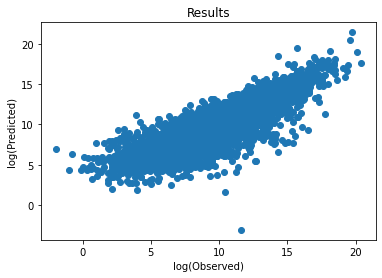

In [46]:
test_restul = model2.evaluate(x_test, np.log(y_test))
math.sqrt(test_restul)
yhat = model2.predict(x_test)
plt.scatter(np.log(y_test), yhat)
plt.title("Results")
plt.xlabel("log(Observed)")
plt.ylabel("log(Predicted)")
plt.show()


# All data no GCN

In [47]:
edges3 = df2018[["tradeflow_comtrade_o", "tradeflow_comtrade_d", "dist", "comlang_off", "comlang_ethno", "comcol", "col45", "comleg_pretrans", "comleg_posttrans", "transition_legalchange","comrelig", "col_dep_ever", "col_dep", "sibling_ever", "sibling",'gdp_o','gdp_d']]

In [48]:
edges3 = edges3.replace(np.nan,0)

In [49]:
scaler = StandardScaler()
mlpIn_scaled = scaler.fit_transform(edges3)
x_train, x_test, y_train, y_test = train_test_split(mlpIn_scaled, target, train_size= .66)
x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, train_size= .50)
model2 = keras.Sequential(
    [
        keras.Input( shape=(len(edges3.columns),) ),
        layers.Dense(10, activation="relu"),
        layers.Dense(5, activation="relu"),
        layers.Dense(1)
    ]
)
model2.compile(loss = 'mean_squared_error', optimizer = 'adam')
fit = model2.fit(x_train, np.log(y_train), epochs=400, validation_data=(x_validation, np.log(y_validation)))

Epoch 1/400
369/369 [==============================] - 1s 2ms/step - loss: 61.1107 - val_loss: 14.9004
Epoch 2/400
369/369 [==============================] - 0s 1ms/step - loss: 13.2831 - val_loss: 12.1861
Epoch 3/400
369/369 [==============================] - 0s 1ms/step - loss: 11.6701 - val_loss: 11.4715
Epoch 4/400
369/369 [==============================] - 0s 1ms/step - loss: 10.9472 - val_loss: 11.1082
Epoch 5/400
369/369 [==============================] - 0s 1ms/step - loss: 10.5801 - val_loss: 10.8230
Epoch 6/400
369/369 [==============================] - 0s 1ms/step - loss: 10.3511 - val_loss: 10.6720
Epoch 7/400
369/369 [==============================] - 0s 1ms/step - loss: 10.2453 - val_loss: 10.5965
Epoch 8/400
369/369 [==============================] - 0s 1ms/step - loss: 10.1327 - val_loss: 10.5190
Epoch 9/400
369/369 [==============================] - 0s 1ms/step - loss: 10.0424 - val_loss: 10.4183
Epoch 10/400
369/369 [==============================] - 0s 1ms/step - los

369/369 [==============================] - 0s 1ms/step - loss: 5.4295 - val_loss: 5.9122
Epoch 82/400
369/369 [==============================] - 0s 1ms/step - loss: 5.4141 - val_loss: 5.9116
Epoch 83/400
369/369 [==============================] - 0s 1ms/step - loss: 5.4303 - val_loss: 6.0127
Epoch 84/400
369/369 [==============================] - 0s 1ms/step - loss: 5.3395 - val_loss: 5.8129
Epoch 85/400
369/369 [==============================] - 0s 1ms/step - loss: 5.3821 - val_loss: 5.8597
Epoch 86/400
369/369 [==============================] - 0s 1ms/step - loss: 5.3225 - val_loss: 5.8053
Epoch 87/400
369/369 [==============================] - 0s 1ms/step - loss: 5.4883 - val_loss: 5.7888
Epoch 88/400
369/369 [==============================] - 0s 1ms/step - loss: 5.4183 - val_loss: 5.8215
Epoch 89/400
369/369 [==============================] - 0s 1ms/step - loss: 5.5008 - val_loss: 5.8983
Epoch 90/400
369/369 [==============================] - 0s 1ms/step - loss: 5.2848 - val_loss: 

Epoch 161/400
369/369 [==============================] - 0s 1ms/step - loss: 5.0020 - val_loss: 5.3854
Epoch 162/400
369/369 [==============================] - 0s 1ms/step - loss: 4.9810 - val_loss: 5.4400
Epoch 163/400
369/369 [==============================] - 0s 1ms/step - loss: 4.9051 - val_loss: 5.3408
Epoch 164/400
369/369 [==============================] - 0s 1ms/step - loss: 5.2270 - val_loss: 5.7255
Epoch 165/400
369/369 [==============================] - 0s 1ms/step - loss: 5.0646 - val_loss: 5.3738
Epoch 166/400
369/369 [==============================] - 0s 1ms/step - loss: 4.8896 - val_loss: 5.3652
Epoch 167/400
369/369 [==============================] - 0s 1ms/step - loss: 4.9787 - val_loss: 8.6266
Epoch 168/400
369/369 [==============================] - 0s 1ms/step - loss: 5.1630 - val_loss: 5.3111
Epoch 169/400
369/369 [==============================] - 0s 1ms/step - loss: 5.0462 - val_loss: 5.3258
Epoch 170/400
369/369 [==============================] - 0s 1ms/step - lo

369/369 [==============================] - 0s 1ms/step - loss: 4.3936 - val_loss: 4.7296
Epoch 241/400
369/369 [==============================] - 0s 1ms/step - loss: 4.2565 - val_loss: 5.6334
Epoch 242/400
369/369 [==============================] - 0s 1ms/step - loss: 4.6744 - val_loss: 4.6544
Epoch 243/400
369/369 [==============================] - 0s 1ms/step - loss: 4.3454 - val_loss: 4.5539
Epoch 244/400
369/369 [==============================] - 0s 1ms/step - loss: 4.8144 - val_loss: 4.5200
Epoch 245/400
369/369 [==============================] - 0s 1ms/step - loss: 4.4932 - val_loss: 4.7029
Epoch 246/400
369/369 [==============================] - 0s 1ms/step - loss: 4.2404 - val_loss: 4.5170
Epoch 247/400
369/369 [==============================] - 0s 1ms/step - loss: 4.2548 - val_loss: 4.5618
Epoch 248/400
369/369 [==============================] - 0s 1ms/step - loss: 4.7512 - val_loss: 4.5041
Epoch 249/400
369/369 [==============================] - 0s 1ms/step - loss: 4.2394 - v

369/369 [==============================] - 0s 1ms/step - loss: 4.0217 - val_loss: 4.3385
Epoch 320/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1835 - val_loss: 4.2779
Epoch 321/400
369/369 [==============================] - 0s 1ms/step - loss: 4.0588 - val_loss: 4.2809
Epoch 322/400
369/369 [==============================] - 0s 1ms/step - loss: 4.3526 - val_loss: 4.2897
Epoch 323/400
369/369 [==============================] - 0s 1ms/step - loss: 4.2783 - val_loss: 4.4138
Epoch 324/400
369/369 [==============================] - 0s 1ms/step - loss: 3.9902 - val_loss: 4.2820
Epoch 325/400
369/369 [==============================] - 0s 1ms/step - loss: 4.2263 - val_loss: 4.2723
Epoch 326/400
369/369 [==============================] - 0s 1ms/step - loss: 4.1978 - val_loss: 4.2953
Epoch 327/400
369/369 [==============================] - 0s 1ms/step - loss: 4.0460 - val_loss: 4.6678
Epoch 328/400
369/369 [==============================] - 0s 1ms/step - loss: 3.9850 - v

369/369 [==============================] - 0s 1ms/step - loss: 3.9590 - val_loss: 4.2206
Epoch 399/400
369/369 [==============================] - 0s 1ms/step - loss: 5.1223 - val_loss: 4.2158
Epoch 400/400
369/369 [==============================] - 0s 1ms/step - loss: 3.9178 - val_loss: 4.1782


95/95 [==============================] - 0s 777us/step


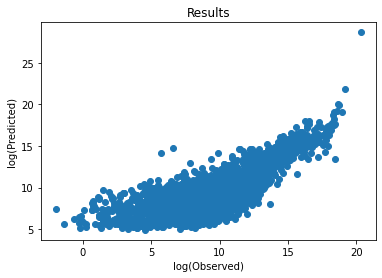

1.5230578450287127

In [50]:
test_restul = model2.evaluate(x_test, np.log(y_test))
math.sqrt(test_restul)
yhat = model2.predict(x_test)
plt.scatter(np.log(y_test), yhat)
plt.title("Results")
plt.xlabel("log(Observed)")
plt.ylabel("log(Predicted)")
plt.show()
mean_absolute_error(np.log(y_test),yhat)

# Regression Decoder

### Regression implementation adapted from Yulia Newton's sample demo on regression. http://alumni.soe.ucsc.edu/~ynewton/

In [51]:
#Start with GCN output
mlpIn = mlpIn[[1,3,4,7,"weight"]]

In [52]:
#From GCN Output
scaler = StandardScaler()
mlpIn_scaled = scaler.fit_transform(mlpIn)
x_train, x_test, y_train, y_test = train_test_split(mlpIn_scaled, target, train_size= .66)
x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, train_size= .50)

In [53]:
model = linear_model.LinearRegression().fit(x_train, np.log(y_train))

In [54]:
y_test_pred = model.predict(x_test)

print('Mean squared error: %.2f' % mean_squared_error(np.log(y_test), y_test_pred))

print('Coefficient of determination: %.2f' % r2_score(np.log(y_test), y_test_pred))

Mean squared error: 5.50
Coefficient of determination: 0.58


In [55]:
y_validation_pred = model.predict(x_validation)
print('Mean squared error: %.2f' % mean_squared_error(np.log(y_validation), y_validation_pred))
print('Coefficient of determination: %.2f' % r2_score(np.log(y_validation), y_validation_pred))

Mean squared error: 5.35
Coefficient of determination: 0.57


Text(0, 0.5, 'Predicted Y')

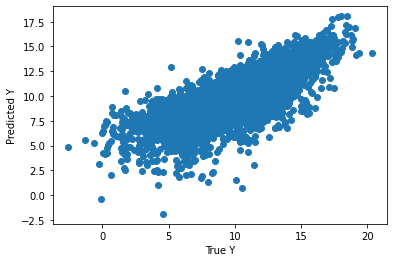

In [56]:
plt.scatter(np.log(y_test),y_test_pred)
plt.xlabel('True Y')
plt.ylabel('Predicted Y')

# GraphSAGE

### GraphSAGE implementaion adapted from the stellargraph library GraphSAGE demo

### https://stellargraph.readthedocs.io/en/stable/demos/embeddings/graphsage-unsupervised-sampler-embeddings.html

In [57]:
edges5 = edges1
G = StellarGraph(nodes, edges5)
nodes2 = list(G.nodes())
number_of_walks = 1
length = 5

In [58]:
unsupervised_samples = UnsupervisedSampler(
    G, nodes=nodes2, length=length, number_of_walks=number_of_walks
)

In [59]:
batch_size = 50
epochs = 4
num_samples = [10, 5]

In [60]:
generator = GraphSAGELinkGenerator(G, batch_size, num_samples)
train_gen = generator.flow(unsupervised_samples)

In [61]:
layer_sizes = [8, 8]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=generator, bias=True, dropout=0.0, normalize="l2"
)

In [62]:
# Build the model and expose input and output sockets of graphsage, for node pair inputs:
x_inp, x_out = graphsage.in_out_tensors()

In [63]:
prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [64]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

In [65]:
history = model.fit(
    train_gen,
    epochs=epochs,
    verbose=1,
    use_multiprocessing=False,
    workers=4,
    shuffle=True,
)

Epoch 1/4
27/27 [==============================] - 3s 36ms/step - loss: 0.8131 - binary_accuracy: 0.5000
Epoch 2/4
27/27 [==============================] - 1s 35ms/step - loss: 0.8131 - binary_accuracy: 0.5000
Epoch 3/4
27/27 [==============================] - 1s 36ms/step - loss: 0.8130 - binary_accuracy: 0.5000
Epoch 4/4
27/27 [==============================] - 1s 37ms/step - loss: 0.8131 - binary_accuracy: 0.5000


In [66]:
x_inp_src = x_inp[0::2]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

In [67]:
node_ids = nodes.index
node_gen = GraphSAGENodeGenerator(G, batch_size, num_samples).flow(nodes2)

In [68]:
node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)

4/4 [==============================] - 0s 13ms/step


In [69]:
embededNode= pd.DataFrame(data=node_embeddings)
embededNode['Country'] = nodes.index
embededNode = embededNode.set_index('Country')

In [70]:
In = list()
Out = list()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
for edge in edges5.source.to_numpy():
    Out.append(embededNode.loc[[edge]])
for edge in edges5.target.to_numpy():
    In.append(embededNode.loc[[edge]])
Out = np.reshape(Out,(17879,8))
In = np.reshape(In,(17879,8))
Out = pd.DataFrame(Out)
In = pd.DataFrame(In)

In [71]:
edges5.pop('source')
edges5.pop('target')
mlpIn = pd.concat([Out,In,edges5.reset_index(drop=True)], axis = 1)

In [72]:
scaler = StandardScaler()
mlpIn_scaled = scaler.fit_transform(mlpIn)
x_train, x_test, y_train, y_test = train_test_split(mlpIn_scaled, target, train_size= .66)
x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, train_size= .50)

In [73]:
model2 = keras.Sequential(
    [
        keras.Input( shape=(len(mlpIn.columns),) ),
        layers.Dense(40, activation="relu"),
        layers.Dense(20, activation="relu"),
        layers.Dense(1)
    ]
)

model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 40)                720       
                                                                 
 dense_15 (Dense)            (None, 20)                820       
                                                                 
 dense_16 (Dense)            (None, 1)                 21        
                                                                 
Total params: 1,561
Trainable params: 1,561
Non-trainable params: 0
_________________________________________________________________


In [74]:
model2.compile(loss = 'mean_squared_error',
             optimizer = 'adam')

In [75]:
fit = model2.fit(x_train, np.log(y_train), epochs=400, validation_data=(x_validation, np.log(y_validation)))

Epoch 1/400
369/369 [==============================] - 1s 2ms/step - loss: 30.4588 - val_loss: 13.9009
Epoch 2/400
369/369 [==============================] - 0s 1ms/step - loss: 10.8709 - val_loss: 10.5497
Epoch 3/400
369/369 [==============================] - 0s 1ms/step - loss: 9.9069 - val_loss: 10.1007
Epoch 4/400
369/369 [==============================] - 0s 1ms/step - loss: 9.7624 - val_loss: 10.3396
Epoch 5/400
369/369 [==============================] - 0s 1ms/step - loss: 9.7225 - val_loss: 10.0482
Epoch 6/400
369/369 [==============================] - 0s 1ms/step - loss: 9.7204 - val_loss: 10.0276
Epoch 7/400
369/369 [==============================] - 0s 1ms/step - loss: 9.7126 - val_loss: 10.0533
Epoch 8/400
369/369 [==============================] - 0s 1ms/step - loss: 9.7003 - val_loss: 9.9476
Epoch 9/400
369/369 [==============================] - 0s 1ms/step - loss: 9.6571 - val_loss: 10.0444
Epoch 10/400
369/369 [==============================] - 0s 1ms/step - loss: 9.659

369/369 [==============================] - 0s 1ms/step - loss: 9.4095 - val_loss: 9.8591
Epoch 82/400
369/369 [==============================] - 0s 1ms/step - loss: 9.4065 - val_loss: 9.8432
Epoch 83/400
369/369 [==============================] - 0s 1ms/step - loss: 9.4169 - val_loss: 9.7598
Epoch 84/400
369/369 [==============================] - 0s 1ms/step - loss: 9.4136 - val_loss: 9.7450
Epoch 85/400
369/369 [==============================] - 0s 1ms/step - loss: 9.3996 - val_loss: 9.7384
Epoch 86/400
369/369 [==============================] - 0s 1ms/step - loss: 9.3991 - val_loss: 9.7680
Epoch 87/400
369/369 [==============================] - 0s 1ms/step - loss: 9.3977 - val_loss: 9.7733
Epoch 88/400
369/369 [==============================] - 0s 1ms/step - loss: 9.4200 - val_loss: 9.7720
Epoch 89/400
369/369 [==============================] - 0s 1ms/step - loss: 9.4099 - val_loss: 9.7885
Epoch 90/400
369/369 [==============================] - 0s 1ms/step - loss: 9.3965 - val_loss: 

Epoch 161/400
369/369 [==============================] - 0s 1ms/step - loss: 9.2893 - val_loss: 9.9084
Epoch 162/400
369/369 [==============================] - 0s 1ms/step - loss: 9.3097 - val_loss: 9.7657
Epoch 163/400
369/369 [==============================] - 0s 1ms/step - loss: 9.2955 - val_loss: 9.8023
Epoch 164/400
369/369 [==============================] - 0s 1ms/step - loss: 9.3037 - val_loss: 9.8136
Epoch 165/400
369/369 [==============================] - 0s 1ms/step - loss: 9.2793 - val_loss: 9.8195
Epoch 166/400
369/369 [==============================] - 0s 1ms/step - loss: 9.2861 - val_loss: 9.7008
Epoch 167/400
369/369 [==============================] - 0s 1ms/step - loss: 9.2923 - val_loss: 9.7312
Epoch 168/400
369/369 [==============================] - 0s 1ms/step - loss: 9.2860 - val_loss: 9.6736
Epoch 169/400
369/369 [==============================] - 0s 1ms/step - loss: 9.2890 - val_loss: 9.7078
Epoch 170/400
369/369 [==============================] - 0s 1ms/step - lo

369/369 [==============================] - 0s 1ms/step - loss: 9.1926 - val_loss: 9.6864
Epoch 241/400
369/369 [==============================] - 0s 1ms/step - loss: 9.1986 - val_loss: 9.8616
Epoch 242/400
369/369 [==============================] - 0s 1ms/step - loss: 9.2348 - val_loss: 9.7090
Epoch 243/400
369/369 [==============================] - 0s 1ms/step - loss: 9.1714 - val_loss: 9.7448
Epoch 244/400
369/369 [==============================] - 0s 1ms/step - loss: 9.1765 - val_loss: 9.6481
Epoch 245/400
369/369 [==============================] - 0s 1ms/step - loss: 9.1971 - val_loss: 9.7533
Epoch 246/400
369/369 [==============================] - 0s 1ms/step - loss: 9.1830 - val_loss: 9.6844
Epoch 247/400
369/369 [==============================] - 0s 1ms/step - loss: 9.1880 - val_loss: 9.7022
Epoch 248/400
369/369 [==============================] - 0s 1ms/step - loss: 9.1674 - val_loss: 9.6883
Epoch 249/400
369/369 [==============================] - 0s 1ms/step - loss: 9.1940 - v

369/369 [==============================] - 0s 1ms/step - loss: 9.0866 - val_loss: 9.6322
Epoch 320/400
369/369 [==============================] - 0s 1ms/step - loss: 9.1035 - val_loss: 9.6062
Epoch 321/400
369/369 [==============================] - 0s 1ms/step - loss: 9.1005 - val_loss: 9.5236
Epoch 322/400
369/369 [==============================] - 0s 1ms/step - loss: 9.0774 - val_loss: 9.8209
Epoch 323/400
369/369 [==============================] - 0s 1ms/step - loss: 9.0854 - val_loss: 9.6469
Epoch 324/400
369/369 [==============================] - 0s 1ms/step - loss: 9.0571 - val_loss: 9.6130
Epoch 325/400
369/369 [==============================] - 0s 1ms/step - loss: 9.1082 - val_loss: 9.6282
Epoch 326/400
369/369 [==============================] - 0s 1ms/step - loss: 9.0871 - val_loss: 9.7095
Epoch 327/400
369/369 [==============================] - 0s 1ms/step - loss: 9.0564 - val_loss: 9.8020
Epoch 328/400
369/369 [==============================] - 0s 1ms/step - loss: 9.1104 - v

369/369 [==============================] - 0s 1ms/step - loss: 8.9972 - val_loss: 9.5720
Epoch 399/400
369/369 [==============================] - 0s 1ms/step - loss: 9.0058 - val_loss: 9.6786
Epoch 400/400
369/369 [==============================] - 0s 1ms/step - loss: 9.0036 - val_loss: 9.5619


95/95 [==============================] - 0s 755us/step


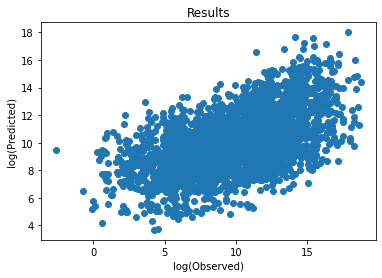

2.3579239925410764

In [76]:
test_restul = model2.evaluate(x_test, np.log(y_test))
math.sqrt(test_restul)
yhat = model2.predict(x_test)
plt.scatter(np.log(y_test), yhat)
plt.title("Results")
plt.xlabel("log(Observed)")
plt.ylabel("log(Predicted)")
plt.show()
mean_absolute_error(np.log(y_test),yhat)

# GraphSAGE more data

In [77]:
edges2 = df2018[["country_id_o", "country_id_d","tradeflow_comtrade_o", "tradeflow_comtrade_d", "dist", "comlang_off", "comlang_ethno", "comcol", "col45", "comleg_pretrans", "comleg_posttrans", "transition_legalchange","comrelig", "col_dep_ever", "col_dep", "sibling_ever", "sibling"]]
edges2 = edges2.replace(np.nan,0)
edges2 = edges2.rename(
    columns={"country_id_o" : "source", "country_id_d" : "target", "dist": "weight"}
)
trade_out = edges2.pop('tradeflow_comtrade_o')
trade_in = edges2.pop('tradeflow_comtrade_d')
edges2['weight'] = np.log(edges2['weight'])

In [78]:
edges5 = edges2
G = StellarGraph(nodes, edges5)
nodes2 = list(G.nodes())
number_of_walks = 1
length = 5

unsupervised_samples = UnsupervisedSampler(
    G, nodes=nodes2, length=length, number_of_walks=number_of_walks
)

batch_size = 50
epochs = 4
num_samples = [10, 5]

generator = GraphSAGELinkGenerator(G, batch_size, num_samples)
train_gen = generator.flow(unsupervised_samples)

layer_sizes = [8, 8]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=generator, bias=True, dropout=0.0, normalize="l2"
)

# Build the model and expose input and output sockets of graphsage, for node pair inputs:
x_inp, x_out = graphsage.in_out_tensors()

prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

history = model.fit(
    train_gen,
    epochs=epochs,
    verbose=1,
    use_multiprocessing=False,
    workers=4,
    shuffle=True,
)

x_inp_src = x_inp[0::2]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

nodes2

node_ids = nodes.index
node_gen = GraphSAGENodeGenerator(G, batch_size, num_samples).flow(nodes2)

node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)

node_embeddings.shape

node_embeddings

embededNode= pd.DataFrame(data=node_embeddings)
embededNode['Country'] = nodes.index
embededNode = embededNode.set_index('Country')

In = list()
Out = list()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
for edge in edges5.source.to_numpy():
    Out.append(embededNode.loc[[edge]])
for edge in edges5.target.to_numpy():
    In.append(embededNode.loc[[edge]])
Out = np.reshape(Out,(17879,8))
In = np.reshape(In,(17879,8))
Out = pd.DataFrame(Out)
In = pd.DataFrame(In)

edges5.pop('source')
edges5.pop('target')
mlpIn = pd.concat([Out,In,edges5.reset_index(drop=True)], axis = 1)
#mlpIn['weight'] = edges1['weight'].values
mlpIn

from tensorflow import keras
from tensorflow.keras import layers

scaler = StandardScaler()
mlpIn_scaled = scaler.fit_transform(mlpIn)
x_train, x_test, y_train, y_test = train_test_split(mlpIn_scaled, target, train_size= .66)
x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, train_size= .50)

model2 = keras.Sequential(
    [
        keras.Input( shape=(len(mlpIn.columns),) ),
        layers.Dense(40, activation="relu"),
        layers.Dense(20, activation="relu"),
        layers.Dense(1)
    ]
)

model2.summary()

model2.compile(loss = 'mean_squared_error',
             optimizer = 'adam')

fit = model2.fit(x_train, np.log(y_train), epochs=400, validation_data=(x_validation, np.log(y_validation)))

link_classification: using 'ip' method to combine node embeddings into edge embeddings
Epoch 1/4
27/27 [==============================] - 3s 35ms/step - loss: 0.8119 - binary_accuracy: 0.5000
Epoch 2/4
27/27 [==============================] - 1s 38ms/step - loss: 0.8119 - binary_accuracy: 0.5000
Epoch 3/4
27/27 [==============================] - 1s 35ms/step - loss: 0.8118 - binary_accuracy: 0.5000
Epoch 4/4
4/4 [==============================] - 0s 16ms/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 40)                1200      
                                                                 
 dense_18 (Dense)            (None, 20)                820       
                                                                 
 dense_19 (Dense)            (None, 1)                 21        
                                                    

Epoch 68/400
369/369 [==============================] - 0s 1ms/step - loss: 3.2180 - val_loss: 3.5250
Epoch 69/400
369/369 [==============================] - 0s 1ms/step - loss: 3.2143 - val_loss: 3.5394
Epoch 70/400
369/369 [==============================] - 0s 1ms/step - loss: 3.2075 - val_loss: 3.5278
Epoch 71/400
369/369 [==============================] - 0s 1ms/step - loss: 3.2203 - val_loss: 3.5354
Epoch 72/400
369/369 [==============================] - 0s 1ms/step - loss: 3.2101 - val_loss: 3.5898
Epoch 73/400
369/369 [==============================] - 0s 1ms/step - loss: 3.2091 - val_loss: 3.5211
Epoch 74/400
369/369 [==============================] - 0s 1ms/step - loss: 3.2079 - val_loss: 3.5821
Epoch 75/400
369/369 [==============================] - 0s 1ms/step - loss: 3.1934 - val_loss: 3.6356
Epoch 76/400
369/369 [==============================] - 0s 1ms/step - loss: 3.2229 - val_loss: 3.5339
Epoch 77/400
369/369 [==============================] - 0s 1ms/step - loss: 3.1973

Epoch 148/400
369/369 [==============================] - 0s 1ms/step - loss: 3.0844 - val_loss: 3.5187
Epoch 149/400
369/369 [==============================] - 0s 1ms/step - loss: 3.0791 - val_loss: 3.4891
Epoch 150/400
369/369 [==============================] - 0s 1ms/step - loss: 3.0708 - val_loss: 3.5061
Epoch 151/400
369/369 [==============================] - 0s 1ms/step - loss: 3.0647 - val_loss: 3.5453
Epoch 152/400
369/369 [==============================] - 0s 1ms/step - loss: 3.0957 - val_loss: 3.4553
Epoch 153/400
369/369 [==============================] - 0s 1ms/step - loss: 3.0650 - val_loss: 3.5121
Epoch 154/400
369/369 [==============================] - 0s 1ms/step - loss: 3.0736 - val_loss: 3.4994
Epoch 155/400
369/369 [==============================] - 0s 1ms/step - loss: 3.0759 - val_loss: 3.4944
Epoch 156/400
369/369 [==============================] - 0s 1ms/step - loss: 3.0715 - val_loss: 3.5084
Epoch 157/400
369/369 [==============================] - 0s 1ms/step - lo

369/369 [==============================] - 0s 1ms/step - loss: 3.0077 - val_loss: 3.5656
Epoch 228/400
369/369 [==============================] - 0s 1ms/step - loss: 2.9884 - val_loss: 3.5332
Epoch 229/400
369/369 [==============================] - 0s 1ms/step - loss: 3.0032 - val_loss: 3.5773
Epoch 230/400
369/369 [==============================] - 0s 1ms/step - loss: 2.9998 - val_loss: 3.6010
Epoch 231/400
369/369 [==============================] - 0s 1ms/step - loss: 2.9876 - val_loss: 3.5235
Epoch 232/400
369/369 [==============================] - 0s 1ms/step - loss: 2.9887 - val_loss: 3.5995
Epoch 233/400
369/369 [==============================] - 0s 1ms/step - loss: 3.0055 - val_loss: 3.5480
Epoch 234/400
369/369 [==============================] - 0s 1ms/step - loss: 2.9941 - val_loss: 3.5476
Epoch 235/400
369/369 [==============================] - 0s 1ms/step - loss: 2.9947 - val_loss: 3.5515
Epoch 236/400
369/369 [==============================] - 0s 1ms/step - loss: 2.9970 - v

369/369 [==============================] - 0s 1ms/step - loss: 2.9289 - val_loss: 3.5621
Epoch 307/400
369/369 [==============================] - 0s 1ms/step - loss: 2.9140 - val_loss: 3.5469
Epoch 308/400
369/369 [==============================] - 0s 1ms/step - loss: 2.9243 - val_loss: 3.5984
Epoch 309/400
369/369 [==============================] - 0s 1ms/step - loss: 2.9297 - val_loss: 3.5774
Epoch 310/400
369/369 [==============================] - 0s 1ms/step - loss: 2.9146 - val_loss: 3.6419
Epoch 311/400
369/369 [==============================] - 0s 1ms/step - loss: 2.9094 - val_loss: 3.6129
Epoch 312/400
369/369 [==============================] - 0s 1ms/step - loss: 2.9233 - val_loss: 3.5774
Epoch 313/400
369/369 [==============================] - 0s 1ms/step - loss: 2.9166 - val_loss: 3.6199
Epoch 314/400
369/369 [==============================] - 0s 1ms/step - loss: 2.9081 - val_loss: 3.5508
Epoch 315/400
369/369 [==============================] - 0s 1ms/step - loss: 2.9219 - v

369/369 [==============================] - 0s 1ms/step - loss: 2.8795 - val_loss: 3.5853
Epoch 386/400
369/369 [==============================] - 0s 1ms/step - loss: 2.8805 - val_loss: 3.6328
Epoch 387/400
369/369 [==============================] - 0s 1ms/step - loss: 2.8822 - val_loss: 3.6712
Epoch 388/400
369/369 [==============================] - 0s 1ms/step - loss: 2.8778 - val_loss: 3.6239
Epoch 389/400
369/369 [==============================] - 0s 1ms/step - loss: 2.8755 - val_loss: 3.6101
Epoch 390/400
369/369 [==============================] - 0s 1ms/step - loss: 2.8880 - val_loss: 3.5929
Epoch 391/400
369/369 [==============================] - 0s 1ms/step - loss: 2.8730 - val_loss: 3.6454
Epoch 392/400
369/369 [==============================] - 0s 1ms/step - loss: 2.8776 - val_loss: 3.6460
Epoch 393/400
369/369 [==============================] - 0s 1ms/step - loss: 2.8884 - val_loss: 3.6352
Epoch 394/400
369/369 [==============================] - 0s 1ms/step - loss: 2.8677 - v

95/95 [==============================] - 0s 755us/step


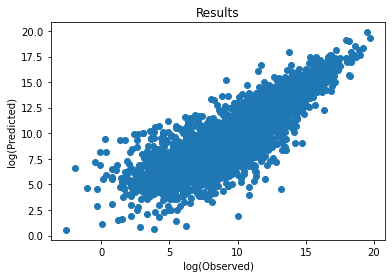

1.4013028698372905

In [79]:
test_restul = model2.evaluate(x_test, np.log(y_test))
math.sqrt(test_restul)
yhat = model2.predict(x_test)
plt.scatter(np.log(y_test), yhat)
plt.title("Results")
plt.xlabel("log(Observed)")
plt.ylabel("log(Predicted)")
plt.show()
mean_absolute_error(np.log(y_test),yhat)

# PCA

In [80]:
edges7 = df2018[["tradeflow_comtrade_o", "tradeflow_comtrade_d", "dist", "comlang_off", "comlang_ethno", "comcol", "col45", "comleg_pretrans", "comleg_posttrans", "transition_legalchange","comrelig", "col_dep_ever", "col_dep", "sibling_ever", "sibling",'gdp_o','gdp_d']]

edges7 = edges7.replace(np.nan,0)

scaler = StandardScaler()
mlpIn_scaled = scaler.fit_transform(edges7)


In [81]:
pca = PCA(n_components=4)   # svd_solverstr {‘auto’, ‘full’, ‘arpack’, ‘randomized’}
pca.fit(mlpIn_scaled)
print(pca.explained_variance_ratio_)

X_transformed = pca.transform(mlpIn_scaled)

[0.19991721 0.12558192 0.10788533 0.08496527]


Epoch 1/400
369/369 [==============================] - 1s 2ms/step - loss: 77.6261 - val_loss: 47.9545
Epoch 2/400
369/369 [==============================] - 0s 1ms/step - loss: 31.9980 - val_loss: 19.1814
Epoch 3/400
369/369 [==============================] - 0s 1ms/step - loss: 19.2155 - val_loss: 14.9720
Epoch 4/400
369/369 [==============================] - 0s 1ms/step - loss: 16.3872 - val_loss: 13.5283
Epoch 5/400
369/369 [==============================] - 0s 1ms/step - loss: 14.9383 - val_loss: 12.8792
Epoch 6/400
369/369 [==============================] - 0s 1ms/step - loss: 14.1061 - val_loss: 12.3639
Epoch 7/400
369/369 [==============================] - 0s 1ms/step - loss: 13.5744 - val_loss: 12.0787
Epoch 8/400
369/369 [==============================] - 0s 1ms/step - loss: 13.1341 - val_loss: 11.9072
Epoch 9/400
369/369 [==============================] - 0s 1ms/step - loss: 12.8494 - val_loss: 11.7218
Epoch 10/400
369/369 [==============================] - 0s 1ms/step - los

Epoch 80/400
369/369 [==============================] - 0s 1ms/step - loss: 11.5131 - val_loss: 11.1039
Epoch 81/400
369/369 [==============================] - 0s 1ms/step - loss: 11.5088 - val_loss: 11.1133
Epoch 82/400
369/369 [==============================] - 0s 1ms/step - loss: 11.4984 - val_loss: 11.0956
Epoch 83/400
369/369 [==============================] - 0s 1ms/step - loss: 11.5062 - val_loss: 11.1078
Epoch 84/400
369/369 [==============================] - 0s 1ms/step - loss: 11.4987 - val_loss: 11.0905
Epoch 85/400
369/369 [==============================] - 0s 1ms/step - loss: 11.5091 - val_loss: 11.0887
Epoch 86/400
369/369 [==============================] - 0s 1ms/step - loss: 11.5014 - val_loss: 11.1279
Epoch 87/400
369/369 [==============================] - 0s 1ms/step - loss: 11.5044 - val_loss: 11.0986
Epoch 88/400
369/369 [==============================] - 0s 1ms/step - loss: 11.5036 - val_loss: 11.1232
Epoch 89/400
369/369 [==============================] - 0s 1ms/s

369/369 [==============================] - 0s 1ms/step - loss: 11.4939 - val_loss: 11.1200
Epoch 159/400
369/369 [==============================] - 0s 1ms/step - loss: 11.4915 - val_loss: 11.1112
Epoch 160/400
369/369 [==============================] - 0s 1ms/step - loss: 11.4972 - val_loss: 11.1401
Epoch 161/400
369/369 [==============================] - 0s 1ms/step - loss: 11.4974 - val_loss: 11.1085
Epoch 162/400
369/369 [==============================] - 0s 1ms/step - loss: 11.5052 - val_loss: 11.1179
Epoch 163/400
369/369 [==============================] - 0s 1ms/step - loss: 11.4984 - val_loss: 11.1061
Epoch 164/400
369/369 [==============================] - 0s 1ms/step - loss: 11.4815 - val_loss: 11.0954
Epoch 165/400
369/369 [==============================] - 0s 1ms/step - loss: 11.4907 - val_loss: 11.0936
Epoch 166/400
369/369 [==============================] - 0s 1ms/step - loss: 11.4914 - val_loss: 11.0917
Epoch 167/400
369/369 [==============================] - 0s 1ms/step 

369/369 [==============================] - 0s 1ms/step - loss: 11.4819 - val_loss: 11.0831
Epoch 237/400
369/369 [==============================] - 0s 1ms/step - loss: 11.4941 - val_loss: 11.0812
Epoch 238/400
369/369 [==============================] - 0s 1ms/step - loss: 11.4937 - val_loss: 11.0766
Epoch 239/400
369/369 [==============================] - 0s 1ms/step - loss: 11.4844 - val_loss: 11.0589
Epoch 240/400
369/369 [==============================] - 0s 1ms/step - loss: 11.5074 - val_loss: 11.0909
Epoch 241/400
369/369 [==============================] - 0s 1ms/step - loss: 11.4804 - val_loss: 11.0758
Epoch 242/400
369/369 [==============================] - 0s 1ms/step - loss: 11.4855 - val_loss: 11.0694
Epoch 243/400
369/369 [==============================] - 0s 1ms/step - loss: 11.4796 - val_loss: 11.0756
Epoch 244/400
369/369 [==============================] - 0s 1ms/step - loss: 11.5005 - val_loss: 11.0712
Epoch 245/400
369/369 [==============================] - 0s 1ms/step 

369/369 [==============================] - 0s 1ms/step - loss: 11.4872 - val_loss: 11.1308
Epoch 315/400
369/369 [==============================] - 0s 1ms/step - loss: 11.4944 - val_loss: 11.0835
Epoch 316/400
369/369 [==============================] - 0s 1ms/step - loss: 11.4631 - val_loss: 11.0846
Epoch 317/400
369/369 [==============================] - 0s 1ms/step - loss: 11.5027 - val_loss: 11.0695
Epoch 318/400
369/369 [==============================] - 0s 1ms/step - loss: 11.4774 - val_loss: 11.1318
Epoch 319/400
369/369 [==============================] - 0s 1ms/step - loss: 11.4645 - val_loss: 11.0823
Epoch 320/400
369/369 [==============================] - 0s 1ms/step - loss: 11.4828 - val_loss: 11.0619
Epoch 321/400
369/369 [==============================] - 0s 1ms/step - loss: 11.4976 - val_loss: 11.0793
Epoch 322/400
369/369 [==============================] - 0s 1ms/step - loss: 11.4812 - val_loss: 11.0928
Epoch 323/400
369/369 [==============================] - 0s 1ms/step 

369/369 [==============================] - 0s 1ms/step - loss: 11.4358 - val_loss: 11.0715
Epoch 393/400
369/369 [==============================] - 0s 1ms/step - loss: 11.4301 - val_loss: 11.0370
Epoch 394/400
369/369 [==============================] - 0s 1ms/step - loss: 11.4192 - val_loss: 11.0271
Epoch 395/400
369/369 [==============================] - 0s 1ms/step - loss: 11.4249 - val_loss: 10.9896
Epoch 396/400
369/369 [==============================] - 0s 1ms/step - loss: 11.4169 - val_loss: 11.0015
Epoch 397/400
369/369 [==============================] - 0s 1ms/step - loss: 11.3994 - val_loss: 10.9747
Epoch 398/400
369/369 [==============================] - 0s 1ms/step - loss: 11.4200 - val_loss: 10.9842
Epoch 399/400
369/369 [==============================] - 0s 1ms/step - loss: 11.4027 - val_loss: 10.9692
Epoch 400/400
95/95 [==============================] - 0s 734us/step


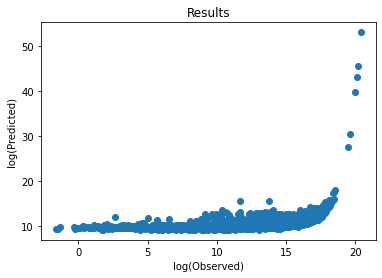

In [82]:
x_train, x_test, y_train, y_test = train_test_split(X_transformed, target, train_size= .66)
x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, train_size= .50)
model2 = keras.Sequential(
    [
        keras.Input( shape=(4,) ),
        layers.Dense(3, activation="relu"),
        layers.Dense(2, activation="relu"),
        layers.Dense(1)
    ]
)
model2.compile(loss = 'mean_squared_error', optimizer = 'adam')
fit = model2.fit(x_train, np.log(y_train), epochs=400, validation_data=(x_validation, np.log(y_validation)))

test_restul = model2.evaluate(x_test, np.log(y_test))
math.sqrt(test_restul)
yhat = model2.predict(x_test)
plt.scatter(np.log(y_test), yhat)
plt.title("Results")
plt.xlabel("log(Observed)")
plt.ylabel("log(Predicted)")
plt.show()